# 7.8 Adam算法

Adam算法在RMSProp算法基础上对小批量随机梯度也做了指数加权移动平均 [1]。下面我们来介绍这个算法。

> 所以Adam算法可以看做是RMSProp算法与动量法的结合。

## 7.8.1 算法

Adam算法使用了动量变量$\boldsymbol{v}_t$和RMSProp算法中小批量随机梯度按元素平方的指数加权移动平均变量$\boldsymbol{s}_t$，并在时间步0将它们中每个元素初始化为0。给定超参数$0 \leq \beta_1 < 1$（算法作者建议设为0.9），时间步$t$的动量变量$\boldsymbol{v}_t$即小批量随机梯度$\boldsymbol{g}_t$的指数加权移动平均：

$$\boldsymbol{v}_t \leftarrow \beta_1 \boldsymbol{v}_{t-1} + (1 - \beta_1) \boldsymbol{g}_t. $$

和RMSProp算法中一样，给定超参数$0 \leq \beta_2 < 1$（算法作者建议设为0.999），
将小批量随机梯度按元素平方后的项$\boldsymbol{g}_t \odot \boldsymbol{g}_t$做指数加权移动平均得到$\boldsymbol{s}_t$：

$$\boldsymbol{s}_t \leftarrow \beta_2 \boldsymbol{s}_{t-1} + (1 - \beta_2) \boldsymbol{g}_t \odot \boldsymbol{g}_t. $$

由于我们将$\boldsymbol{v}_0$和$\boldsymbol{s}_0$中的元素都初始化为0，
在时间步$t$我们得到$\boldsymbol{v}_t =  (1-\beta_1) \sum_{i=1}^t \beta_1^{t-i} \boldsymbol{g}_i$。将过去各时间步小批量随机梯度的权值相加，得到 $(1-\beta_1) \sum_{i=1}^t \beta_1^{t-i} = 1 - \beta_1^t$。需要注意的是，当$t$较小时，过去各时间步小批量随机梯度权值之和会较小。例如，当$\beta_1 = 0.9$时，$\boldsymbol{v}_1 = 0.1\boldsymbol{g}_1$。为了消除这样的影响，对于任意时间步$t$，我们可以将$\boldsymbol{v}_t$再除以$1 - \beta_1^t$，从而使过去各时间步小批量随机梯度权值之和为1。这也叫作偏差修正。在Adam算法中，我们对变量$\boldsymbol{v}_t$和$\boldsymbol{s}_t$均作偏差修正：

$$\hat{\boldsymbol{v}}_t \leftarrow \frac{\boldsymbol{v}_t}{1 - \beta_1^t}, $$

$$\hat{\boldsymbol{s}}_t \leftarrow \frac{\boldsymbol{s}_t}{1 - \beta_2^t}. $$


接下来，Adam算法使用以上偏差修正后的变量$\hat{\boldsymbol{v}}_t$和$\hat{\boldsymbol{s}}_t$，将模型参数中每个元素的学习率通过按元素运算重新调整：

$$\boldsymbol{g}_t' \leftarrow \frac{\eta \hat{\boldsymbol{v}}_t}{\sqrt{\hat{\boldsymbol{s}}_t} + \epsilon},$$

其中$\eta$是学习率，$\epsilon$是为了维持数值稳定性而添加的常数，如$10^{-8}$。和AdaGrad算法、RMSProp算法以及AdaDelta算法一样，目标函数自变量中每个元素都分别拥有自己的学习率。最后，使用$\boldsymbol{g}_t'$迭代自变量：

$$\boldsymbol{x}_t \leftarrow \boldsymbol{x}_{t-1} - \boldsymbol{g}_t'. $$

## 7.8.2 从零开始实现

我们按照Adam算法中的公式实现该算法。其中时间步$t$通过`hyperparams`参数传入`adam`函数。

In [1]:
%matplotlib inline
import torch
import sys
sys.path.append("..") 

import d2lzh_pytorch as d2l

In [5]:

features, labels = d2l.get_data_ch7()


def init_adam_states():
    v_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    v_b = torch.zeros(1, dtype=torch.float32)
    
    s_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    s_b = torch.zeros(1, dtype=torch.float32)
    
    return ((v_w, s_w), (v_b, s_b))


def adam(params, states, hyperparams):
    
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    
    for p, (v, s) in zip(params, states):
        v[:] = beta1 * v + (1 - beta1) * p.grad.data
        s[:] = beta2 * s + (1 - beta2) * p.grad.data**2
        
        v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
        s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
        
        p.data -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr) + eps)
        pass
        
    hyperparams['t'] += 1

使用学习率为0.01的Adam算法来训练模型。

loss: 0.245776, 0.025707 sec per epoch


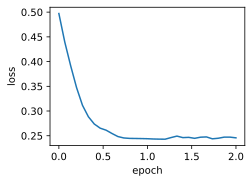

In [6]:

# 训练
d2l.train_ch7(adam, init_adam_states(), 
              {'lr': 0.01, 't': 1}, 
              features, labels)

## 7.8.3 简洁实现

通过名称为“Adam”的优化器实例，我们便可使用PyTorch提供的Adam算法。

loss: 0.244486, 0.025409 sec per epoch


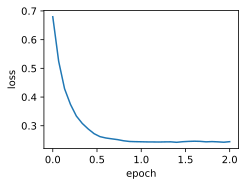

In [7]:

# 简洁实现 Adam算法
d2l.train_pytorch_ch7(torch.optim.Adam, 
                      {'lr': 0.01}, 
                      features, 
                      labels
                     )

## 小结

* Adam算法在RMSProp算法的基础上对小批量随机梯度也做了指数加权移动平均。
* Adam算法使用了偏差修正。


## 参考文献

[1] Kingma, D. P., & Ba, J. (2014). Adam: A method for stochastic optimization. arXiv preprint arXiv:1412.6980.